## (Trying to be) Simple demonstration of Multiview Conformal Prediction

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import copy
from typing import Any, Callable, Optional, Tuple
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from scipy.special import softmax

In [2]:
# check GPU environment

if torch.cuda.is_available():
    num_of_gpus = torch.cuda.device_count()
    print(f"Number of GPUs: {num_of_gpus}")
    #for i in range(num_of_gpus):
    #    freemem, _ = torch.cuda.mem_get_info(i)
    #    print(f"GPU {i}, free memory {freemem/1024} MB")


Number of GPUs: 8


In [5]:
# set your device manually
device = "cuda:2"
freemem, _ = torch.cuda.mem_get_info(device)
print(f"Using device: {device}, free memory {freemem/1024/1024} MB")

Using device: cuda:2, free memory 15378.9375 MB


In [6]:
# function to extract quadrant from PIL image

def index_to_quadrant_id(index):
    # works w/ integers and numpy arrays
    img_index = index // 4
    quadrant_id = index % 4
    return img_index, quadrant_id

def get_quadrant(img, quadrant_id):
    # PIL image -> PIL image
    w, h = img.size
    match quadrant_id:
    # quadrant ID is 0:top_left, 1:top_right, 2:bottom_left, 3:bottom_right
        case 0:
            window = (0, 0, w//2, h//2)
        case 1:
            window = (w//2, 0, w, h//2)
        case 2:
            window = (0, h//2, w//2, h)
        case 3:
            window = (w//2, h//2, w, h)
        case _:
            print("Invalid quadrant ID")
    img = img.crop(window)
    img = img.resize((w, h))
    return img

In [7]:
# we want to define a new dataset for taking out image quadrants from CIFAR
# to do this, we will write a superclass for CIFAR dataset

class CIFAR10_Quadrants(torchvision.datasets.CIFAR10):
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Accesses a quadrant of an image in CIFAR
        Args:
            index (int): quadrant-based index, which is equal to 4*image_index + quadrant ID
            quadrant ID is 0:top_left, 1:top_right, 2:bottom_left, 3:bottom_right
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img_index, quadrant_id = index_to_quadrant_id(index)
        img, target = self.data[img_index], int(self.targets[img_index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)
        img = get_quadrant(img, quadrant_id)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target, index

    def __len__(self):
        return len(self.data) * 4

In [8]:
# load the CIFAR data into our custom dataset

data_root_dir = "/workspace/datasets/"
if_download = True # set this to false if you don't want to accidentally write anything to disk

input_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
data_tr = CIFAR10_Quadrants(root=data_root_dir, train=True, transform=input_transform, download=if_download)
data_te = CIFAR10_Quadrants(root=data_root_dir, train=False, transform=input_transform, download=if_download)
print(f"CIFAR10: # training quadrants = {len(data_tr)}, # test quadrants = {len(data_te)}")

Files already downloaded and verified
Files already downloaded and verified
CIFAR10: # training quadrants = 200000, # test quadrants = 40000


In [35]:
# yield the following
# training dataloader using quadrants from 90% of the examples
# calibration dataloader using quadrants from 10% of the examples
# test dataloader

batch_size = 16

n_calibration_set = len(data_tr) // 10
assert n_calibration_set % 4 == 0

data_tr_subset = torch.utils.data.Subset(data_tr, np.arange(0, len(data_tr)-n_calibration_set))
data_va_subset = torch.utils.data.Subset(data_tr, np.arange(len(data_tr)-n_calibration_set, len(data_tr)))
loader_tr = torch.utils.data.DataLoader(data_tr_subset, batch_size=batch_size, shuffle=True)
loader_va = torch.utils.data.DataLoader(data_va_subset, batch_size=batch_size, shuffle=True)
loader_te = torch.utils.data.DataLoader(data_te, batch_size=batch_size, shuffle=False)

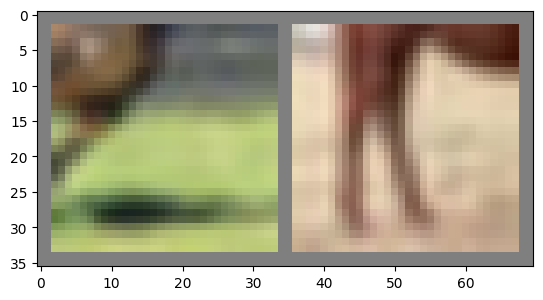

['horse', 'horse']
tensor([45480, 49363])
tensor([3, 2])


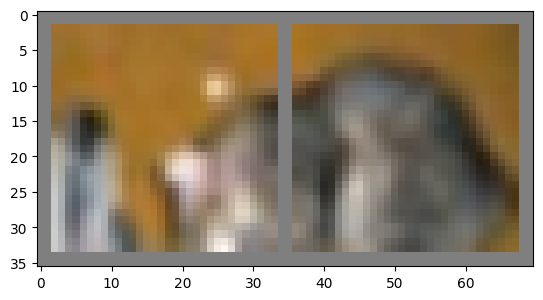

['cat', 'cat']
tensor([0, 0])
tensor([0, 1])


In [10]:
# print some images as a sanity check

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataiter = iter(loader_va)
images, labels, indices = next(dataiter)
indices, quads = index_to_quadrant_id(indices)
imshow(torchvision.utils.make_grid(images))
print([classes[j] for j in labels])
print(indices)
print(quads)

dataiter = iter(loader_te)
images, labels, indices = next(dataiter)
indices, quads = index_to_quadrant_id(indices)
imshow(torchvision.utils.make_grid(images))
print([classes[j] for j in labels])
print(indices)
print(quads)

In [11]:
# instantiate a small neural network
# architecture: LeNet-5 implementation: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [22]:
# define a label bank object that stores network predictions during training
# the size of the label bank is Nx4xExC, N=tr.set, E=#epochs, C=#classes

N_classes = len(classes)
N_training_samples = len(data_tr)

def evolve_labels(preds_history):
    # preds_history is a length-E list of NxC arrays of logits
    preds_history_softmax = [softmax(arr, axis=1) for arr in preds_history]
    preds_history_softmax = np.array(preds_history_softmax)
    augmented_labels = np.mean(preds_history_softmax, axis=0)
    return augmented_labels

# facilitation of label evolution
def label_evolution_loop(loader_tr, loader_va, n_epochs, reset_weights=True, n_evolutions=1):
    model = Net()

    augmented_labels = None
    augmented_labels_tab = []
    for ne in range(n_evolutions):
        print(f"Label evolution iteration: {ne}")
        if reset_weights and ne >= 1:
            model = Net()
            print(f"Model weights re-initialized")
        model, model_preds_history = train_loop(model, loader_tr, loader_va, n_epochs, augmented_labels)
        augmented_labels = evolve_labels(model_preds_history)
        augmented_labels_tab.append(augmented_labels)

    return model, augmented_labels_tab

# main training loop, augmented labels are optional non one-hot labels
def train_loop(model, loader_tr, loader_va, n_epochs, augmented_labels=None):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    model_preds_history = []

    for i in range(n_epochs):
        model, model_preds_i = train_epoch(model, optimizer, loader_tr, loader_va, augmented_labels, i)
        model_preds_history.append(model_preds_i)

    return model, model_preds_history

def train_epoch(model, optimizer, loader_tr, loader_va, augmented_labels=None, epoch_number=-1):
    #model.train() if layer behaviors vary between train/test (eg. dropout)
    model.to(device)

    # train and record the model outputs
    preds = np.zeros((N_training_samples, N_classes))
    loss_running = []
    acc_running = []
    for data in tqdm(loader_tr):
        imgs, targets, indices = data
        if augmented_labels is None:
            targets_gpu = targets.to(device)
        else:
            targets_gpu = torch.Tensor(augmented_labels[indices]).to(device)
        imgs = imgs.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = F.cross_entropy(outputs, targets_gpu)
        loss.backward()
        optimizer.step()

        logits = outputs.detach().cpu().numpy() # BxC
        for b in range(logits.shape[0]):
            preds[indices[b], :] = logits[b, :]
        loss_running.append(loss.item())
        acc_running.append(np.mean(np.argmax(logits,axis=1) == targets.numpy()))

    # validate on the calibration set
    loss_running_val = []
    acc_running_val = []
    for data in tqdm(loader_va):
        imgs, targets, indices = data[0].to(device), data[1], data[2]
        
        outputs = model(imgs)
        loss = F.cross_entropy(outputs, targets.to(device))
        
        logits = outputs.detach().cpu().numpy() # BxC
        for b in range(logits.shape[0]):
            preds[indices[b], :] = logits[b, :]

        loss_running_val.append(loss.item())
        acc_running_val.append(np.mean(np.argmax(logits,axis=1) == targets.numpy()))

    print("Epoch %2d, train loss/acc: %2.3f/%2.3f, val loss/acc: %2.3f/%2.3f" % 
          (epoch_number, np.mean(loss_running), np.mean(acc_running), np.mean(loss_running_val), np.mean(acc_running_val)))

    return model, preds
        

In [ ]:
# train the model

model, labels_tab = label_evolution_loop(loader_tr, loader_va, n_epochs=40, reset_weights=True, n_evolutions=3)
save_path = './cifar_net.pth'
torch.save(model.state_dict(), save_path)

Label evolution iteration: 0


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:09<00:00, 135.41it/s]


Epoch  0, train loss/acc: 1.904/0.293, val loss/acc: 1.788/0.350


 39%|██████████████████████████████▍                                              | 4438/11250 [00:44<01:05, 103.59it/s]